In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# import albumentations as A
# from albumentations.pytorch import transforms
from fastai2.vision.all import get_image_files, AdaptiveConcatPool2d, \
    aug_transforms, show_image, show_images, load_image, PoolFlatten, \
    PoolType
from itertools import zip_longest
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pytorch_lightning as pl
# from pytorch_lightning.logging.comet import CometLogger
# from pytorch_lightning.loggers import MLFlowLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision as tv
import warnings

from htools import *
from incendio.optimizers import variable_lr_optimizer
from img_wang.data import get_databunch, load_img
from img_wang.models import Unmixer, Encoder

/opt/conda/envs/fastai/lib/python3.7/site-packages/incendio/callbacks.py:24: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [4]:
cd_root()

Current directory: /storage/img-wang


In [6]:
class UnmixerPL(pl.LightningModule):
    
    def __init__(self, net=None, loss=F.mse_loss):
        super().__init__()
        self.net = net or Unmixer()
        self.loss = loss
        
    def forward(self, *x):
        return self.net(*x)
    
    def training_step(self, batch, batch_i):
        *x, y = batch
        y_hat = self(*x)
        loss = self.loss(y_hat, y)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_i):
        *x, y = batch
        y_hat = self(*x)
        loss = self.loss(y_hat, y)
        res = pl.EvalResult(checkpoint_on=loss)
        res.log('val_loss', loss)
        return res
    
    def configure_optimizers(self):
        return variable_lr_optimizer(self.net)

In [7]:
class MixupDataPL(pl.LightningDataModule):
    
    def __init__(self, dir_=None, paths=None,
                 mode:('mixup', 'scale', 'quadrant')='mixup', bs=32,
                 valid_bs_mult=1, train_pct=.9, shuffle_train=True,
                 drop_last=True, random_state=0, **ds_kwargs):
        self.dst, self.dsv, self.dlt, self.dlv = get_databunch(
            dir_, paths, mode, bs, valid_bs_mult, train_pct, shuffle_train,
            drop_last, random_state, **ds_kwargs
        )
        
    def train_dataloader(self):
        return self.dlt
    
    def val_dataloader(self):
        return self.dlv

In [8]:
dir_u = Path('data/imagewang-160/unsup/')

In [11]:
paths_xtiny = get_image_files(dir_u)[:4]
data = MixupDataPL(paths=paths_xtiny, mode='scale', bs=2, train_pct=.5, n=1)
module = UnmixerPL()

In [12]:
with open('/Users/hmamin/.comet.config', 'r') as f:
    comet_key = f.readlines()[-1].split('=')[-1].strip()
logger = CometLogger(api_key=comet_key, project_name='imagewang')

CometLogger will be initialized in online mode


In [13]:
mlf_logger = MLFlowLogger(experiment_name='debug-img-wang', 
                          tracking_uri='http://127.0.0.1:5000')

In [14]:
t = pl.Trainer(max_epochs=5, logger=mlf_logger, log_save_interval=1)
t.fit(module, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type    | Params
---------------------------------
0 | net  | Unmixer | 394 K 


1

## Supervised Task

Try out the slightly more straightforward supervised task to see if that trains as expected with incendio and/or lightning. Trying to narrow down possible problems.

In [138]:
x = load_image('data/imagewang-160/train/n01440764/ILSVRC2012_val_00000293.jpeg')
x = np.array(x, dtype=np.float32)

In [9]:
class SupervisedDataPL(pl.LightningDataModule):
    
    def __init__(self, root='data/imagewang-160', bs=32, train_tfms=None,
                 val_tfms=None, shape=(128, 128)):
        """
        tfms: list[transform]
        """
        self.root = Path(root)
        self.bs = bs
        self.train_tfms = tv.transforms.Compose(
            train_tfms or 
            [tv.transforms.RandomResizedCrop(shape, (.9, 1.0)), 
             tv.transforms.RandomHorizontalFlip(),
             tv.transforms.RandomRotation(10),
             tv.transforms.ToTensor()]
        )
        self.val_tfms = tv.transforms.Compose(
            val_tfms or 
            [tv.transforms.Resize(shape),
             tv.transforms.ToTensor()])
        
    def setup(self, stage=''):
        self.ds_train = ImageFolder(self.root/'train', self.train_tfms)
        self.ds_val = ImageFolder(self.root/'val', self.val_tfms)
        self.ds_val.classes = self.ds_train.classes
        self.ds_val.class_to_idx = self.ds_train.class_to_idx
        self.dl_train = DataLoader(self.ds_train, self.bs, shuffle=True)
        self.dl_val = DataLoader(self.ds_val, self.bs)
        
    def train_dataloader(self):
        return self.dl_train
    
    def val_dataloader(self):
        return self.dl_val

In [10]:
class SupervisedEncoderClassifier(nn.Module):
    
    def __init__(self, enc=None, n_classes=20):
        super().__init__()
        self.n_classes = n_classes
        
        # Layers
        self.enc = enc or Encoder()
        self.pool = PoolFlatten('cat')
        # Concat pool doubles last feature dimension.
        self.fc = nn.Linear(list(self.enc.parameters())[-1].shape[0]*2,
                            n_classes)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.pool(x)
        return self.fc(x).squeeze()

In [11]:
sdata = SupervisedDataPL(bs=2)
sdata.setup()

In [333]:
net = SupervisedEncoderClassifier()

In [334]:
x, y = next(iter(sdata.dl_train))
x.shape, y.shape

(torch.Size([2, 3, 128, 128]), torch.Size([2]))

In [336]:
yhat = net(x)
yhat.shape

torch.Size([2, 20])

In [340]:
yhat.dtype, y.dtype

(torch.float32, torch.int64)

In [351]:
module = UnmixerPL(net, loss=F.cross_entropy)

In [352]:
t = pl.Trainer(max_epochs=5, overfit_batches=1)
t.fit(module, sdata)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type                        | Params
-----------------------------------------------------
0 | net  | SupervisedEncoderClassifier | 404 K 


/Users/hmamin/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:22: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

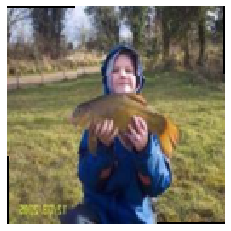

In [355]:
show_image(x[0])

In [356]:
with torch.no_grad():
    yhat = net(x)

In [360]:
F.softmax(yhat, dim=-1).argmax(-1)

tensor([18, 18])

In [361]:
y

tensor([0, 0])

## Incendio

Supervised problem. Finally works on small subset!

In [64]:
from copy import copy

from incendio.callbacks import MetricHistory
from incendio.core import Trainer

In [13]:
def ds_subset(ds, n, random=False, attr='samples'):
    ds = copy(ds)
    samples = getattr(ds, attr)
    setattr(ds, attr, [samples[i] for i in np.random.randint(0, len(ds), n)] \
            if random else samples[:n])
    return ds

In [26]:
dst = ds_subset(sdata.ds_train, 400, True)
dsv = ds_subset(sdata.ds_val, 40, True)
dst

Dataset ImageFolder
    Number of datapoints: 400
    Root location: data/imagewang-160/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(128, 128), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )

In [27]:
train_bs, val_bs = 8, 8
# No shuffling for debugging purposes.
dlt = DataLoader(dst, batch_size=train_bs, shuffle=False)
dlv = DataLoader(dsv, batch_size=val_bs, shuffle=False)

In [28]:
for i, (*x, y) in enumerate(dlt):
    print(smap(*x, y), y)
    if i > 3: break

[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 8, 18,  0, 16, 17,  0, 16, 16])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 2, 19,  7, 19, 13,  0, 15, 17])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 0, 15, 18,  0,  1, 15,  0, 17])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([15,  3, 19, 16, 13, 14, 17, 15])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([16, 14,  8, 16, 19, 17, 16,  8])


In [29]:
net = SupervisedEncoderClassifier()

In [30]:
t = Trainer(net, dst, dsv, dlt, dlv, F.cross_entropy, 'multiclass', 
            'data/models/v0', callbacks=[MetricHistory(None, None)])

In [31]:
t.fit(10)

2020-08-23 00:52:15,208 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-23 00:52:17,320
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  3.0521 |       6.2169 |

=====




2020-08-23 00:52:18,914
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.6752 |       5.5996 |

=====




2020-08-23 00:52:20,198
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.5463 |       5.5759 |

=====




2020-08-23 00:52:21,721
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.4247 |       5.2378 |

=====




2020-08-23 00:52:23,063
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.3461 |       4.9975 |

=====




2020-08-23 00:52:24,374
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.3110 |       4.6047 |

=====




2020-08-23 00:52:25,728
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.2089 |       5.1317 |

=====




2020-08-23 00:52:27,294
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.1145 |       4.8552 |

=====




2020-08-23 00:52:28,601
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0751 |       4.9417 |

=====




2020-08-23 00:52:29,978
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0398 |       4.6526 |

=====

2020-08-23 00:52:29,980
 Training complete. Model in eval mode.


TypeError: join() argument must be str or bytes, not 'NoneType'

In [442]:
# len(dst)=40, len(dsv)=4, bs_t=8, bs_v=4
# t.fit(10)

2020-08-15 23:15:18,657 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-15 23:15:20,367
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  3.5978 |       3.0423 |

=====




2020-08-15 23:15:22,601
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0457 |       4.7251 |

=====




2020-08-15 23:15:24,867
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.5868 |       5.0436 |

=====




2020-08-15 23:15:27,515
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.3469 |       4.7424 |

=====




2020-08-15 23:15:29,797
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.1580 |       4.7005 |

=====




2020-08-15 23:15:31,752
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.0070 |       5.0885 |

=====




2020-08-15 23:15:33,580
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7909 |       4.7962 |

=====




2020-08-15 23:15:35,467
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7043 |       4.5786 |

=====




2020-08-15 23:15:37,684
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5834 |       6.2987 |

=====




2020-08-15 23:15:39,805
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5468 |       5.8891 |

=====

2020-08-15 23:15:39,820
 Training complete. Model in eval mode.


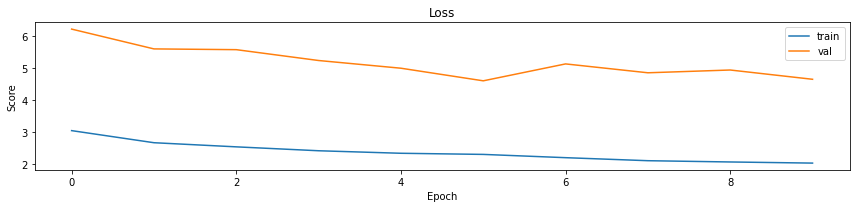

In [33]:
t.callbacks['MetricHistory'].plot()

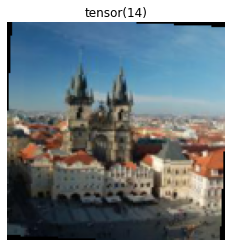

In [45]:
show_image(x[0][1], title=y[1])

In [51]:
net(x[0].to(t.device)).argmax(-1)

tensor([ 8, 14,  8, 17, 19, 17, 16,  0], device='cuda:0')

In [443]:
*x, y = next(iter(dlt))
smap(*x, y)

[torch.Size([8, 3, 128, 128]), torch.Size([8])]

In [444]:
y

tensor([14, 15,  8, 17, 14,  0,  1,  8])

In [446]:
F.softmax(net(*x), dim=-1).argmax(-1)

tensor([14, 15, 18, 15, 14,  0, 12,  8])

In [447]:
F.cross_entropy(net(*x), y)

tensor(1.0842, grad_fn=<NllLossBackward>)

## Incendio - Unsupervised Scale Dataset (multi-label classification)

Use new classification mode to try out scale dataset unsupervised task.

In [52]:
from img_wang.models import MLPHead
from incendio.callbacks import MetricHistory

In [53]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='scale', 
                                   bs=3, train_pct=.5, max_train_len=3,
                                   max_val_len=3, regression=False)
lmap(len, dst, dsv, dlt, dlv)

[3, 3, 1, 1]

In [54]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

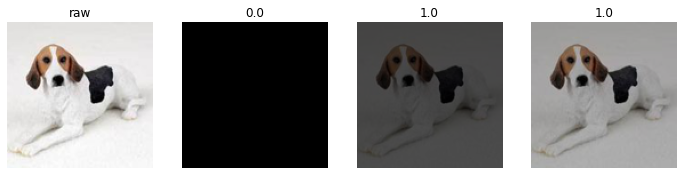

In [55]:
show_images(x, titles=['raw']+y.tolist())

In [56]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3])]

In [57]:
net = Unmixer(
    Encoder(fs=(8, 32), strides=(1, 1)),
    MLPHead(64, last_act=None)
)

/storage/img-wang/lib/img_wang/models.py:180: UserWarning: Temperature is ignored when last activation is not softmax or log_softmax.
  warnings.warn('Temperature is ignored when last activation is '


In [58]:
net(*xb)

tensor([[ -0.3124, -19.9564, -16.2769],
        [-16.3375,  -0.2602,  -7.9657],
        [ -0.2330,  -9.4995, -13.9104]], grad_fn=<SqueezeBackward1>)

In [59]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            'binary', 'data/models/v0', callbacks=[MetricHistory(None, None)])

/opt/conda/envs/fastai/lib/python3.7/site-packages/incendio/core.py:236: UserWarning: Last activation is None for a classification problem. This means your network must include a sigmoid or softmax at the end if you wish to compute any metrics using soft predictions.
  'Last activation is None for a classification problem. This '


In [60]:
t.fit(5)

2020-08-23 01:14:26,101 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-23 01:14:26,266
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  8.5605 |       0.6790 |

=====




2020-08-23 01:14:26,346
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2282 |       0.6720 |

=====




2020-08-23 01:14:26,423
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2368 |       0.6459 |

=====




2020-08-23 01:14:26,499
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2437 |       0.6106 |

=====




2020-08-23 01:14:26,585
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2294 |       0.5393 |

=====

2020-08-23 01:14:26,586
 Training complete. Model in eval mode.


TypeError: join() argument must be str or bytes, not 'NoneType'

In [70]:
torch.sigmoid(t.net(*map(lambda x: x.to(t.device), xb)))

tensor([[0.4247, 0.7644, 0.5834],
        [0.7502, 0.4278, 0.5778],
        [0.4407, 0.5927, 0.6610]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [71]:
yb

tensor([[0., 1., 1.],
        [1., 0., 1.],
        [0., 1., 1.]])

## Incendio - Unsupervised Scale Dataset (regression)

Use new regression mode to try out scale dataset unsupervised task.

In [83]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='scale', 
                                   bs=3, train_pct=.5, max_train_len=3,
                                   max_val_len=3, regression=True)
lmap(len, dst, dsv, dlt, dlv)

[3, 3, 1, 1]

In [84]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

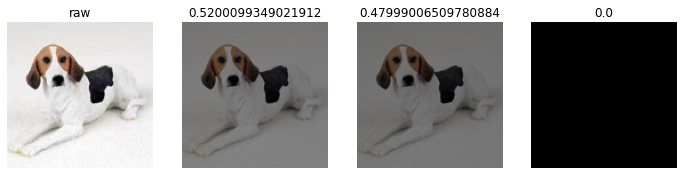

In [85]:
show_images(x, titles=['raw']+y.tolist())

In [86]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3])]

In [87]:
# net = Unmixer(
#     Encoder(fs=(8, 32, 128), strides=(1, 1, 1)),
#     MLPHead(256, last_act='sigmoid')
# )

net = Unmixer(
    Encoder(),
    MLPHead(512, last_act='sigmoid')
)

In [88]:
net(*xb).shape

torch.Size([3, 3])

In [89]:
yb.shape

torch.Size([3, 3])

In [90]:
class PairwiseLossReduction(nn.Module):
    
    @valuecheck
    def __init__(self, reduce:('sum', 'mean')='mean', **kwargs):
        super().__init__()
        self.distance = nn.PairwiseDistance(**kwargs)
        self.reduce = getattr(torch, reduce)
        
    def forward(self, y_proba, y_true):
        return self.reduce(self.distance(y_proba, y_true))

In [91]:
PairwiseLossReduction()(net(*xb), yb)

tensor(0.6375, grad_fn=<MeanBackward0>)

In [92]:
t = Trainer(net, dst, dsv, dlt, dlv, PairwiseLossReduction(),
            'regression', 'data/models/v0', callbacks=[MetricHistory(None, None)])

In [93]:
t.fit(25, 3e-4)

2020-08-23 01:19:39,398 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0003
    weight_decay: 0
)




2020-08-23 01:19:39,625
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6252 |       0.5225 |

=====




2020-08-23 01:19:39,723
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8933 |       0.6744 |

=====




2020-08-23 01:19:39,818
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8080 |       0.5614 |

=====




2020-08-23 01:19:39,979
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8136 |       0.5137 |

=====




2020-08-23 01:19:40,094
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8163 |       0.5669 |

=====




2020-08-23 01:19:40,237
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8111 |       0.5807 |

=====




2020-08-23 01:19:40,330
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8369 |       0.4944 |

=====




2020-08-23 01:19:40,498
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7636 |       0.5554 |

=====




2020-08-23 01:19:40,592
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7412 |       0.5256 |

=====




2020-08-23 01:19:40,679
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7224 |       0.5772 |

=====




2020-08-23 01:19:40,763
 
=====

Epoch 10

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7208 |       0.6781 |

=====




2020-08-23 01:19:40,848
 
=====

Epoch 11

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7195 |       0.6588 |

=====




2020-08-23 01:19:40,938
 
=====

Epoch 12

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8948 |       0.7973 |

=====




2020-08-23 01:19:41,024
 
=====

Epoch 13

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7557 |       0.6935 |

=====




2020-08-23 01:19:41,109
 
=====

Epoch 14

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7462 |       0.7104 |

=====




2020-08-23 01:19:41,219
 
=====

Epoch 15

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7186 |       0.7054 |

=====




2020-08-23 01:19:41,463
 
=====

Epoch 16

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7817 |       0.6873 |

=====




2020-08-23 01:19:41,642
 
=====

Epoch 17

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7527 |       0.7107 |

=====




2020-08-23 01:19:41,748
 
=====

Epoch 18

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7399 |       0.6842 |

=====




2020-08-23 01:19:41,839
 
=====

Epoch 19

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7507 |       0.7199 |

=====




2020-08-23 01:19:41,921
 
=====

Epoch 20

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7321 |       0.7213 |

=====




2020-08-23 01:19:42,003
 
=====

Epoch 21

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7208 |       0.6802 |

=====




2020-08-23 01:19:42,084
 
=====

Epoch 22

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7245 |       0.7239 |

=====




2020-08-23 01:19:42,170
 
=====

Epoch 23

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7451 |       0.6868 |

=====




2020-08-23 01:19:42,290
 
=====

Epoch 24

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7448 |       0.7140 |

=====

2020-08-23 01:19:42,292
 Training complete. Model in eval mode.


TypeError: join() argument must be str or bytes, not 'NoneType'

In [96]:
t.net(*map(lambda x: x.to(t.device), xb))

tensor([[1.2730e-04, 3.8234e-07, 5.8576e-03],
        [4.2592e-05, 7.6918e-03, 1.3156e-05],
        [2.1917e-14, 1.1910e-09, 7.2039e-04]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [97]:
yb

tensor([[0.2288, 0.7712, 0.0000],
        [0.2611, 0.0000, 0.7389],
        [0.6665, 0.3335, 0.0000]])

Looks like net predicts near zero for everything.

## Incendio - Unsupervised Mixup Dataset (multi-label classification)

Use new classification mode to try out scale dataset unsupervised task.

In [35]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='mixup', 
                                   bs=2, train_pct=.5, max_train_len=6,
                                   max_val_len=6, regression=False)
lmap(len, dst, dsv, dlt, dlv)

[4, 4, 2, 2]

In [36]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

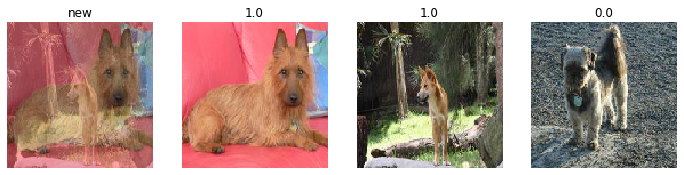

In [37]:
show_images(x, titles=['new']+y.tolist())

In [38]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3])]

In [46]:
net = Unmixer(
    Encoder(fs=(8, 32, 128), strides=(1, 1, 1)),
    MLPHead(256, last_act=None)
)

In [47]:
net(*xb)

tensor([[-2.2372, -0.9814, -1.5090],
        [-0.9710, -0.0075, -0.9996]], grad_fn=<SqueezeBackward1>)

In [48]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            'binary', 'data/models/v0', callbacks=[MetricHistory()])

2020-08-16 21:25:01,465 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-16 21:25:09,132
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  7.2365 |       0.6909 |

=====




2020-08-16 21:25:16,256
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  3.0412 |       0.6423 |

=====




2020-08-16 21:25:23,203
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8503 |       0.6649 |

=====




2020-08-16 21:25:29,915
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6596 |       0.6459 |

=====




2020-08-16 21:25:36,803
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6658 |       0.6489 |

=====




2020-08-16 21:25:44,120
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7025 |       0.6553 |

=====




2020-08-16 21:25:52,577
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6735 |       0.6277 |

=====




2020-08-16 21:26:01,682
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6304 |       0.6439 |

=====




2020-08-16 21:26:10,626
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6551 |       0.6400 |

=====




2020-08-16 21:26:18,925
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6450 |       0.6167 |

=====

2020-08-16 21:26:18,928
 Training complete. Model in eval mode.


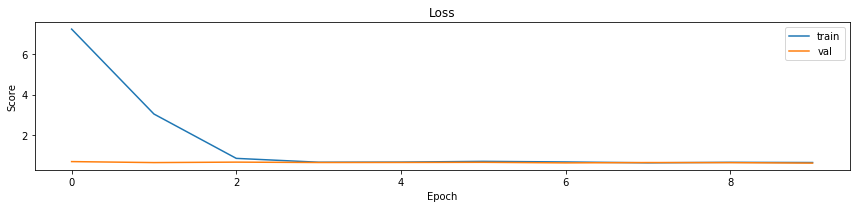

In [49]:
t.fit(10)

In [50]:
torch.sigmoid(t.net(*xb))

tensor([[0.6355, 0.6413, 0.6569],
        [0.6140, 0.6591, 0.6511]], grad_fn=<SigmoidBackward>)

In [51]:
yb

tensor([[1., 0., 1.],
        [0., 1., 1.]])

In [52]:
xb[0]

tensor([[[[0.2270, 0.2087, 0.2529,  ..., 0.2001, 0.2279, 0.2850],
          [0.2873, 0.1895, 0.4711,  ..., 0.5885, 0.2810, 0.1671],
          [0.2596, 0.2886, 0.5595,  ..., 0.5949, 0.2981, 0.1976],
          ...,
          [0.2569, 0.2795, 0.2138,  ..., 0.5309, 0.2242, 0.3457],
          [0.1980, 0.1506, 0.1286,  ..., 0.4048, 0.2495, 0.2614],
          [0.2061, 0.1605, 0.1453,  ..., 0.1658, 0.2288, 0.4077]],

         [[0.2723, 0.2515, 0.2984,  ..., 0.2482, 0.2760, 0.3331],
          [0.3301, 0.2323, 0.5167,  ..., 0.6366, 0.3291, 0.2152],
          [0.3052, 0.3341, 0.6051,  ..., 0.6405, 0.3437, 0.2431],
          ...,
          [0.3154, 0.3380, 0.2723,  ..., 0.5450, 0.2354, 0.3570],
          [0.2691, 0.2217, 0.1921,  ..., 0.4189, 0.2608, 0.2712],
          [0.2769, 0.2314, 0.2137,  ..., 0.1785, 0.2415, 0.4204]],

         [[0.2686, 0.2529, 0.2984,  ..., 0.2381, 0.2658, 0.3230],
          [0.3315, 0.2337, 0.5167,  ..., 0.6316, 0.3240, 0.2101],
          [0.3103, 0.3392, 0.6101,  ..., 0

## Scratch

Wanted to figure out a way to make a cached property that accepts arguments but I think this would require a totally different implementation than what I've built in htools. I guess `__get__` doesn't receive args or kwargs because it's intended for attribute access.

In [146]:
class set_once:
    
    def __init__(self, func):
        self.func = func

    def __get__(self, instance, cls, *args, **kwargs):
        """This method is called when the variable being accessed is not in the
        instance's state dict. The next time the attribute is accessed, the
        computed value will be in the state dict so this method (and the method
        in the instance itself) is not called again unless the attribute is
        deleted.
        """
        print(args, kwargs)
        # When attribute accessed as class method, instance is None.
        if instance is None:
            return self

        # When accessed as instance method, call method on instance as usual.
        # Then set instance attribute and return value.
        val = self.func(instance, *args, **kwargs)
        setattr(instance, self.func.__name__, val)
        return val

In [150]:
class Foo:
    
    def __init__(self, a=None):
        self.a = a
        
    @set_once
    def dim(self, x):
        print('calling dim function')
        return len(x) // 2
    
    def __call__(self, x):
        try:
            dim = self.dim
        except:
            print('except')
            dim = self.dim(x)
        return x / dim

In [151]:
f = Foo(3)

In [152]:
f(np.arange(4))

() {}
except
() {}


TypeError: dim() missing 1 required positional argument: 'x'